In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating crystallized cognition and parental education level, state id
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_cryst_uncorrected','reshist_addr1_adi_edu_high','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_edu_high'].median()
data.loc[data['reshist_addr1_adi_edu_high'] <= val, 'reshist_addr1_adi_edu_high_bin'] = 0
data.loc[data['reshist_addr1_adi_edu_high'] > val, 'reshist_addr1_adi_edu_high_bin'] = 1

In [4]:
data['nihtbx_cryst_uncorrected_log']= np.log(data['nihtbx_cryst_uncorrected']) #natural logarithm to fix skew-tailed data
col='nihtbx_cryst_uncorrected_log'
data['nihtbx_cryst_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0) #standardization

In [63]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
edu = data.reshist_addr1_adi_edu_high_bin.values
target_values = data.nihtbx_cryst_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
edu_ = shared(edu)

In [9]:
#varying intercepts and varying slopes: 
#predicting crystallized cognition scores from census education level 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per state, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * edu_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 588 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


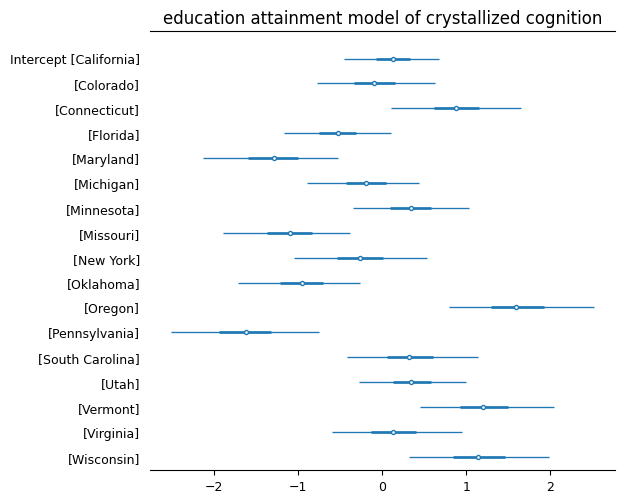

In [10]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("education attainment model of crystallized cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_edu_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_55959/782116851.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


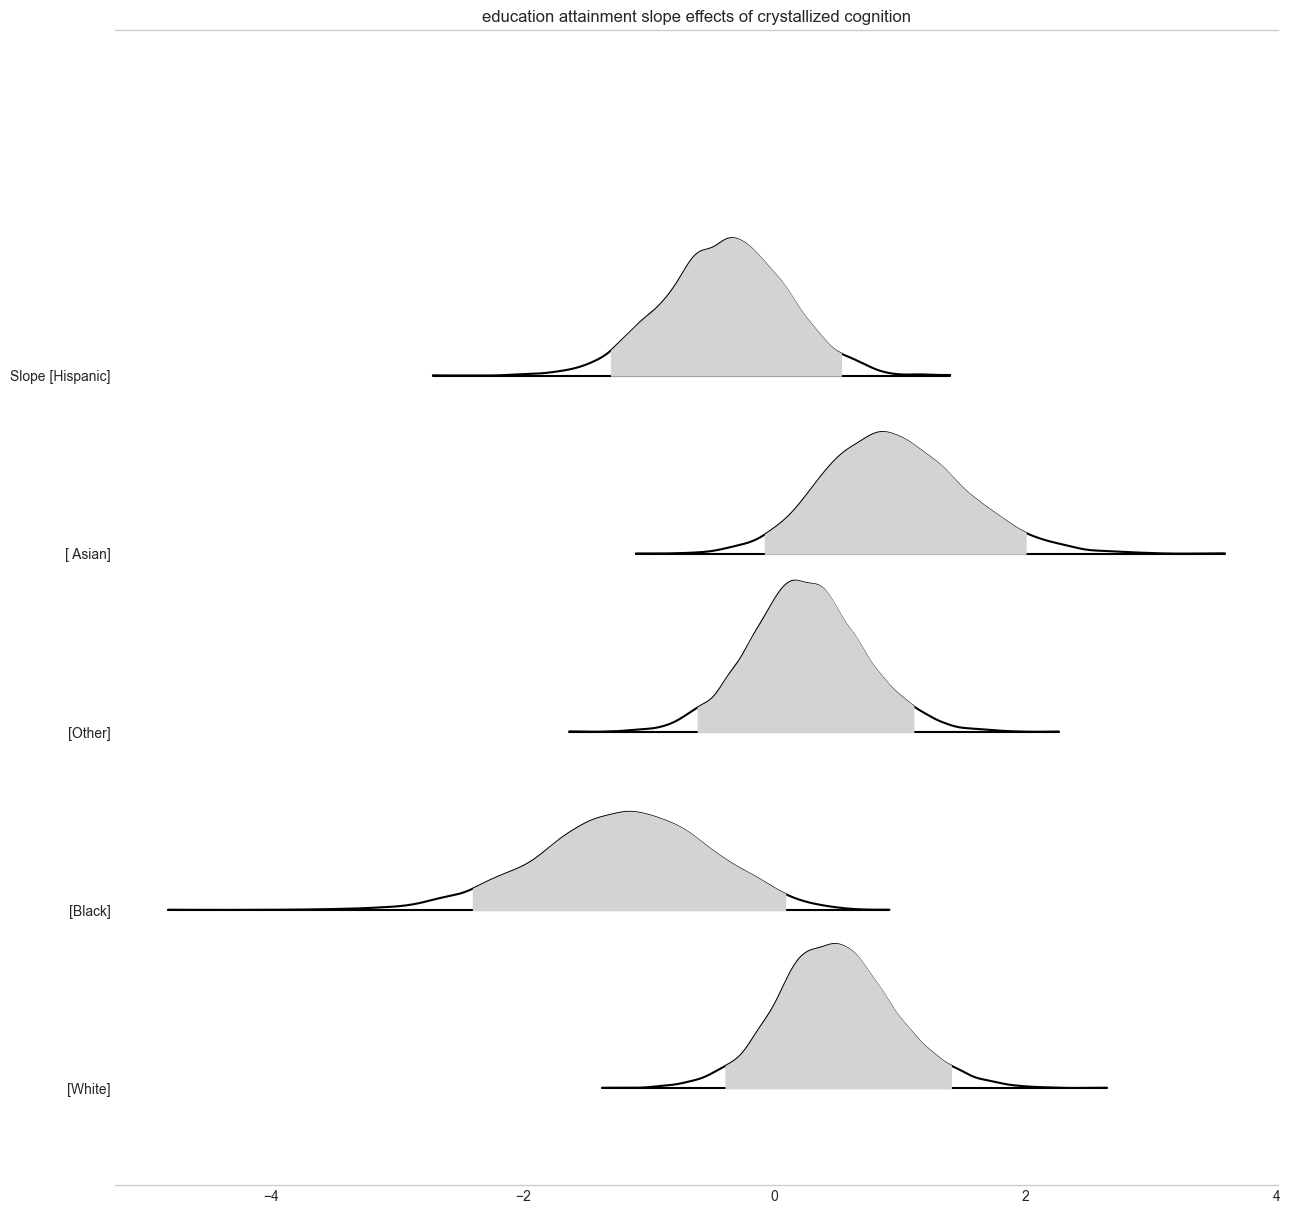

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("education attainment slope effects of crystallized cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_edu_crystallized_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.360258
r2_std    0.003419
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [15]:
# get race, state and parental education attain columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_edu_df = pd.DataFrame(data['reshist_addr1_adi_edu_high_bin'],columns =['reshist_addr1_adi_edu_high_bin']).reset_index(drop=True)


In [16]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_edu_df,ppc_df,left_index=True, right_index=True)


In [17]:
ppc_edu_race_mean = (ppc_df.groupby(['reshist_addr1_adi_edu_high_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_edu_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.270741 -0.107381 -0.287818   
                               Black          -0.284685 -0.309315 -0.363016   
                               Hispanic       -0.230007 -0.300636 -0.286013   
                               Other          -0.250472 -0.349225 -0.300446   
                               White          -0.262274 -0.257668 -0.266250   
1.0                            Asian           0.512937  0.597754  0.533832   
                               Black          -0.330409 -0.390214 -0.185715   
                               Hispanic       -0.026005  0.051959 -0.032156   
                               Other           0.292602  0.269268  0.244918   
                               White           0.405642  0.375202  0.386700   

                                               pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.189362 -0.319731 -0.486544   
                               Black          -0.303576 -0.348889 -0.372636   
                               Hispanic       -0.235911 -0.244930 -0.285684   
                               Other          -0.279037 -0.275721 -0.294540   
                               White          -0.240581 -0.241556 -0.251145   
1.0                            Asian           0.362278  0.527280  0.563356   
                               Black          -0.363615 -0.364710 -0.231960   
                               Hispanic        0.034024  0.119787  0.002157   
                               Other           0.222448  0.251027  0.170347   
                               White           0.357082  0.372002  0.370585   

                                               pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_edu_high_bin race_ethnicity                                 
0.0                            Asian          -0.260313 -0.222108 -0.277918   
                               Black          -0.390587 -0.316094 -0.316523   
                               Hispanic       -0.282525 -0.274996 -0.261097   
                               Other          -0.258592 -0.340109 -0.303497   
                               White          -0.257144 -0.222659 -0.237401   
1.0                            Asian           0.306629  0.492149  0.612626   
                               Black          -0.347867 -0.459657 -0.269101   
                               Hispanic       -0.023506 -0.076067  0.094431   
                               Other           0.074357  0.197350  0.323681   
                               White           0.379184  0.414416  0.348550   

                                               pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_edu_high_bin race_ethnicity            ...                
0.0                            Asian          -0.176440  ...    -0.350661   
                               Black          -0.304670  ...    -0.332618   
                               Hispanic       -0.236611  ...    -0.257246   
                               Other          -0.329705  ...    -0.259240   
                               White          -0.243787  ...    -0.237325   
1.0                            Asian           0.557842  ...     0.421657   
                               Black          -0.416911  ...    -0.420802   
                               Hispanic        0.114695  ...    -0.045197   
                               Other           0.269493  ...     0.185475   
                               White           0.342750  ...     0.365389   

                                               pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_edu_high_bin race_ethnicity                             
0.0                            Asian             -0.193182    -0.240563   
                               Black             -

In [18]:
ppc_edu_race_mean_summ=ppc_edu_race_mean.mean(axis=1)
ppc_edu_race_mean_summ

reshist_addr1_adi_edu_high_bin  race_ethnicity
0.0                             Asian            -0.232541
                                Black            -0.342205
                                Hispanic         -0.265509
                                Other            -0.292175
                                White            -0.255886
1.0                             Asian             0.539402
                                Black            -0.348147
                                Hispanic          0.016643
                                Other             0.244713
                                White             0.365708
dtype: float64

In [19]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.235177,0.347833,0.242614,0.166760,0.227073,0.191239,0.105687,0.238995,0.296990,0.297590,...,0.147924,0.226937,0.284376,0.220758,0.287308,0.478197,0.364501,0.297072,0.334019,0.172777
Black,-0.294028,-0.325845,-0.326790,-0.315843,-0.352121,-0.343892,-0.381858,-0.345427,-0.306834,-0.327603,...,-0.350636,-0.380574,-0.378171,-0.303705,-0.345240,-0.378353,-0.333663,-0.366241,-0.296056,-0.407923
Hispanic,-0.180572,-0.215192,-0.224497,-0.170498,-0.156549,-0.215933,-0.219757,-0.226790,-0.174943,-0.151480,...,-0.205861,-0.142966,-0.176076,-0.178887,-0.168676,-0.200519,-0.224054,-0.171512,-0.219534,-0.197851
Other,0.031388,-0.028221,-0.017397,-0.018761,-0.002334,-0.053259,-0.085788,-0.061162,0.022014,-0.018715,...,-0.028428,-0.014056,-0.009704,0.003960,-0.018476,-0.025279,-0.000146,-0.035229,-0.026371,0.000386
White,0.181459,0.162782,0.167540,0.156478,0.166063,0.161904,0.165603,0.200584,0.151878,0.145881,...,0.163090,0.119869,0.161247,0.170066,0.132649,0.133415,0.126226,0.169034,0.142339,0.148950


In [20]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [21]:
ppc_edu_state_mean = (ppc_df.groupby(['reshist_addr1_adi_edu_high_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_edu_state_mean_summ = ppc_edu_state_mean.mean(axis=1)


In [22]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [23]:
ppc_edu_state_mean_summ_list=ppc_edu_state_mean_summ.to_numpy()
low_edu_state = ppc_edu_state_mean_summ_list[:17]
high_edu_state = ppc_edu_state_mean_summ_list[-17:]

In [24]:
mean_predictions_state = [low_edu_state,high_edu_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.239329,-0.271485,-0.130584,-0.332602,-0.441469,-0.284710,-0.208907,-0.414212,-0.295725,-0.394610,-0.030154,-0.489163,-0.212563,-0.206906,-0.088584,-0.238171,-0.092233
1,0.282354,0.265140,0.386847,0.105475,0.038595,0.206442,0.329901,0.036470,0.253275,0.120837,0.512410,-0.026985,0.292263,0.353975,0.496751,0.257744,0.450133


In [25]:
ppc_edu_race_mean_summ_list=ppc_edu_race_mean_summ.to_numpy()
low_edu_race = ppc_edu_race_mean_summ_list[:5]
high_edu_race = ppc_edu_race_mean_summ_list[-5:]

In [26]:
# initialize list of lists 
mean_predictions_race = [low_edu_race,high_edu_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,-0.232541,-0.342205,-0.265509,-0.292175,-0.255886
1,0.539402,-0.348147,0.016643,0.244713,0.365708


In [27]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','Education_LT12years_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [28]:
val = census_data['Education_LT12years_score'].median()
census_data.loc[census_data['Education_LT12years_score'] < val, 'Education_LT12years_score_bin'] = 0
census_data.loc[census_data['Education_LT12years_score'] >= val, 'Education_LT12years_score_bin'] = 1

In [29]:
census = (census_data.groupby(['state','race_ethnicity','Education_LT12years_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Education_LT12years_score_bin,freq
0,california,Asian,0.0,947674
1,california,Asian,1.0,887641
2,california,Black,0.0,17420
3,california,Black,1.0,3937055
4,california,Hispanic,0.0,774189
...,...,...,...,...
131,wisconsin,Black,1.0,53760
132,wisconsin,Hispanic,0.0,88054
133,wisconsin,Other,0.0,183517
134,wisconsin,White,0.0,4111680


In [30]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Education_LT12years_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,947674,1,0
1,california,Asian,1.0,887641,1,0
2,california,Black,0.0,17420,3,0
3,california,Black,1.0,3937055,3,0
4,california,Hispanic,0.0,774189,0,0


In [31]:
#fix theano shared tensor type error
census=census.astype({'Education_LT12years_score_bin':'uint8'})

In [32]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_edu = census.Education_LT12years_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
edu_.set_value(ps_edu)

In [33]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [34]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(136, 8000)

In [35]:
censust=census
censust

,state,race_ethnicity,Education_LT12years_score_bin,freq,race_enc,state_enc
0,california,Asian,0,947674,1,0
1,california,Asian,1,887641,1,0
2,california,Black,0,17420,3,0
3,california,Black,1,3937055,3,0
4,california,Hispanic,0,774189,0,0
...,...,...,...,...,...,...
131,wisconsin,Black,1,53760,3,16
132,wisconsin,Hispanic,0,88054,0,16
133,wisconsin,Other,0,183517,2,16
134,wisconsin,White,0,4111680,4,16


In [36]:
# get race, state, and parental education attainment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_edu_df2 = pd.DataFrame(censust['Education_LT12years_score_bin'],columns =['Education_LT12years_score_bin']).reset_index(drop=True)


In [37]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_edu_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Education_LT12years_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,947674,-1.612426,-0.218515,-1.573210,0.616488,-1.524077,-0.133031,...,-0.655156,-1.626900,-0.934629,0.449192,-0.070682,-0.456914,-0.245933,-0.127861,-0.663608,0.216463
1,california,Asian,1,887641,-0.307252,0.541017,0.571429,-0.475919,-0.000688,-0.086327,...,0.144381,0.547562,0.436086,1.031040,-0.055183,1.647073,-0.417444,0.337758,-0.102893,-0.121505
2,california,Black,0,17420,0.506190,-0.008572,-0.360349,0.137999,1.098604,-1.273683,...,0.352670,-0.221445,0.565857,-0.587326,1.450778,-0.113817,0.597693,-0.439168,-1.150380,-1.536069
3,california,Black,1,3937055,-0.466016,0.318294,0.373663,1.033599,1.773401,-0.880838,...,1.978893,-0.698429,-0.343536,-1.432100,-0.218968,-1.497362,-0.283199,-0.358800,-2.101617,-0.008925
4,california,Hispanic,0,774189,-1.364692,0.145922,-0.799422,0.311796,-2.341393,1.325652,...,-1.199864,0.733055,-0.902292,0.110158,0.072663,-0.655764,-1.814341,1.455228,-0.741332,0.042831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,wisconsin,Black,1,53760,0.720835,0.767076,-0.647985,-0.292975,-0.142045,-0.366574,...,0.816560,-0.413394,-0.348095,-0.482177,-1.484415,-0.786621,0.191259,-0.263373,0.425887,0.172801
132,wisconsin,Hispanic,0,88054,0.769130,-1.087863,-0.599764,-0.793215,-0.622577,0.809361,...,-0.973684,1.362104,-1.630708,0.498501,0.468646,-0.355061,0.315326,-0.340908,-1.160864,0.550510
133,wisconsin,Other,0,183517,-0.770086,-0.926817,-0.254826,-0.756193,-0.733746,0.418241,...,-0.439341,0.000962,-0.609213,-1.483879,0.704888,-0.845516,-2.162102,-1.215391,0.005352,-0.965162
134,wisconsin,White,0,4111680,-1.252727,0.906884,1.009318,1.437110,0.033205,-0.892100,...,-1.664428,-0.564161,0.384907,-0.012618,-0.893071,0.401525,-1.530779,0.638314,-2.364757,1.225927


In [38]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Education_LT12years_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -1.528054e+06   
                          1                             1   -2.727291e+05   
           Black          0                             2    8.817835e+03   
                          1                             3   -1.834732e+06   
           Hispanic       0                             4   -1.056529e+06   
...                                                                   ...   
wisconsin  Black          1                             131  3.875207e+04   
           Hispanic       0                             132  6.772501e+04   
           Other          0                             133 -1.413238e+05   
           White          0                             134 -5.150814e+06   
                          1                             135  3.394173e+04   

                                                                 pp_cog_1  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -2.070808e+05   
                          1                             1    4.802289e+05   
           Black          0                             2   -1.493234e+02   
                          1                             3    1.253142e+06   
           Hispanic       0                             4    1.129716e+05   
...                                                                   ...   
wisconsin  Black          1                             131  4.123799e+04   
           Hispanic       0                             132 -9.579070e+04   
           Other          0                             133 -1.700867e+05   
           White          0                             134  3.728817e+06   
                          1                             135  2.579156e+04   

                                                                 pp_cog_2  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0   -1.490890e+06   
                          1                             1    5.072241e+05   
           Black          0                             2   -6.277283e+03   
                          1                             3    1.471133e+06   
           Hispanic       0                             4   -6.189036e+05   
...                                                                   ...   
wisconsin  Black          1                             131 -3.483565e+04   
           Hispanic       0                             132 -5.281166e+04   
           Other          0                             133 -4.676483e+04   
           White          0                             134  4.149994e+06   
                          1                             135  1.315575e+05   

                                                                 pp_cog_3  \
state      race_ethnicity Education_LT12years_score_bin                     
california Asian          0                             0    5.842292e+05   
                          1                             1   -4.224455e+05   
           Black          0                             2    2.403935e+03   
                          1                             3    4.069335e+06   
           Hispanic       0                             4    2.413888e+05   
...                                                                   ...   
wisconsin  Black          1                             131 -1.575033e+04   
           Hispanic       0                             132 -6.984572e+04   
           Other          0                             133 -1.387742e+05   
           White          0                             134  5.908938e+06   
                          1                             135  1.355182e+05   

                                                         

In [39]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-1.528054e+06,-2.070808e+05,-1.490890e+06,5.842292e+05,-1.444329e+06,-1.260698e+05,-2.454952e+06,1.338436e+04,1.504767e+06,-9.219992e+05,...,-6.208747e+05,-1.541771e+06,-8.857237e+05,4.256875e+05,-6.698336e+04,-4.330057e+05,-2.330643e+05,-1.211701e+05,-6.288837e+05,2.051366e+05
1,-2.727291e+05,4.802289e+05,5.072241e+05,-4.224455e+05,-6.104988e+02,-7.662761e+04,2.354164e+05,4.281259e+04,1.176602e+06,7.369548e+05,...,1.281589e+05,4.860388e+05,3.870878e+05,9.151935e+05,-4.898298e+04,1.462009e+06,-3.705408e+05,2.998080e+05,-9.133165e+04,-1.078525e+05
2,8.817835e+03,-1.493234e+02,-6.277283e+03,2.403935e+03,1.913768e+04,-2.218756e+04,-1.460064e+04,8.548555e+03,-1.077968e+04,-5.058397e+03,...,6.143520e+03,-3.857567e+03,9.857232e+03,-1.023121e+04,2.527256e+04,-1.982691e+03,1.041182e+04,-7.650311e+03,-2.003961e+04,-2.675832e+04
3,-1.834732e+06,1.253142e+06,1.471133e+06,4.069335e+06,6.981978e+06,-3.467906e+06,-1.939390e+06,-6.854162e+06,-3.581516e+06,4.900966e+04,...,7.791012e+06,-2.749755e+06,-1.352521e+06,-5.638255e+06,-8.620904e+05,-5.895196e+06,-1.114970e+06,-1.412616e+06,-8.274181e+06,-3.513879e+04
4,-1.056529e+06,1.129716e+05,-6.189036e+05,2.413888e+05,-1.812681e+06,1.026305e+06,5.658903e+05,-1.261453e+06,3.489885e+05,-1.510981e+06,...,-9.289213e+05,5.675228e+05,-6.985446e+05,8.528345e+04,5.625518e+04,-5.076850e+05,-1.404643e+06,1.126621e+06,-5.739308e+05,3.315944e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3.875207e+04,4.123799e+04,-3.483565e+04,-1.575033e+04,-7.636347e+03,-1.970700e+04,-1.832027e+04,4.753427e+04,1.837970e+04,-6.811949e+03,...,4.389827e+04,-2.222405e+04,-1.871357e+04,-2.592181e+04,-7.980216e+04,-4.228873e+04,1.028210e+04,-1.415894e+04,2.289571e+04,9.289794e+03
132,6.772501e+04,-9.579070e+04,-5.281166e+04,-6.984572e+04,-5.482039e+04,7.126748e+04,-1.018661e+05,1.423941e+05,1.086026e+05,-1.113699e+05,...,-8.573675e+04,1.199387e+05,-1.435904e+05,4.389504e+04,4.126612e+04,-3.126450e+04,2.776574e+04,-3.001835e+04,-1.022187e+05,4.847458e+04
133,-1.413238e+05,-1.700867e+05,-4.676483e+04,-1.387742e+05,-1.346548e+05,7.675428e+04,2.497471e+05,7.162249e+04,-8.864781e+04,-2.461110e+05,...,-8.062646e+04,1.765087e+02,-1.118010e+05,-2.723169e+05,1.293590e+05,-1.551666e+05,-3.967824e+05,-2.230448e+05,9.821586e+02,-1.771236e+05
134,-5.150814e+06,3.728817e+06,4.149994e+06,5.908938e+06,1.365271e+05,-3.668030e+06,2.634279e+06,1.715161e+06,1.575997e+06,-1.485139e+06,...,-6.843597e+06,-2.319649e+06,1.582614e+06,-5.187961e+04,-3.672022e+06,1.650941e+06,-6.294073e+06,2.624543e+06,-9.723126e+06,5.040619e+06


In [40]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Education_LT12years_score_bin,freq
0,california,Asian,0,947674
1,california,Asian,1,887641
2,california,Black,0,17420
3,california,Black,1,3937055
4,california,Hispanic,0,774189
...,...,...,...,...
131,wisconsin,Black,1,53760
132,wisconsin,Hispanic,0,88054
133,wisconsin,Other,0,183517
134,wisconsin,White,0,4111680


In [41]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Education_LT12years_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,947674,-1.528054e+06,-2.070808e+05,-1.490890e+06,5.842292e+05,-1.444329e+06,-1.260698e+05,...,-6.208747e+05,-1.541771e+06,-8.857237e+05,4.256875e+05,-6.698336e+04,-4.330057e+05,-2.330643e+05,-1.211701e+05,-6.288837e+05,2.051366e+05
1,california,Asian,1,887641,-2.727291e+05,4.802289e+05,5.072241e+05,-4.224455e+05,-6.104988e+02,-7.662761e+04,...,1.281589e+05,4.860388e+05,3.870878e+05,9.151935e+05,-4.898298e+04,1.462009e+06,-3.705408e+05,2.998080e+05,-9.133165e+04,-1.078525e+05
2,california,Black,0,17420,8.817835e+03,-1.493234e+02,-6.277283e+03,2.403935e+03,1.913768e+04,-2.218756e+04,...,6.143520e+03,-3.857567e+03,9.857232e+03,-1.023121e+04,2.527256e+04,-1.982691e+03,1.041182e+04,-7.650311e+03,-2.003961e+04,-2.675832e+04
3,california,Black,1,3937055,-1.834732e+06,1.253142e+06,1.471133e+06,4.069335e+06,6.981978e+06,-3.467906e+06,...,7.791012e+06,-2.749755e+06,-1.352521e+06,-5.638255e+06,-8.620904e+05,-5.895196e+06,-1.114970e+06,-1.412616e+06,-8.274181e+06,-3.513879e+04
4,california,Hispanic,0,774189,-1.056529e+06,1.129716e+05,-6.189036e+05,2.413888e+05,-1.812681e+06,1.026305e+06,...,-9.289213e+05,5.675228e+05,-6.985446e+05,8.528345e+04,5.625518e+04,-5.076850e+05,-1.404643e+06,1.126621e+06,-5.739308e+05,3.315944e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,wisconsin,Black,1,53760,3.875207e+04,4.123799e+04,-3.483565e+04,-1.575033e+04,-7.636347e+03,-1.970700e+04,...,4.389827e+04,-2.222405e+04,-1.871357e+04,-2.592181e+04,-7.980216e+04,-4.228873e+04,1.028210e+04,-1.415894e+04,2.289571e+04,9.289794e+03
132,wisconsin,Hispanic,0,88054,6.772501e+04,-9.579070e+04,-5.281166e+04,-6.984572e+04,-5.482039e+04,7.126748e+04,...,-8.573675e+04,1.199387e+05,-1.435904e+05,4.389504e+04,4.126612e+04,-3.126450e+04,2.776574e+04,-3.001835e+04,-1.022187e+05,4.847458e+04
133,wisconsin,Other,0,183517,-1.413238e+05,-1.700867e+05,-4.676483e+04,-1.387742e+05,-1.346548e+05,7.675428e+04,...,-8.062646e+04,1.765087e+02,-1.118010e+05,-2.723169e+05,1.293590e+05,-1.551666e+05,-3.967824e+05,-2.230448e+05,9.821586e+02,-1.771236e+05
134,wisconsin,White,0,4111680,-5.150814e+06,3.728817e+06,4.149994e+06,5.908938e+06,1.365271e+05,-3.668030e+06,...,-6.843597e+06,-2.319649e+06,1.582614e+06,-5.187961e+04,-3.672022e+06,1.650941e+06,-6.294073e+06,2.624543e+06,-9.723126e+06,5.040619e+06


In [42]:
#final step of poststratification - by race & edu 
#data-weighted average
ppc_edu_race_poststrat = ppc_poststrat_df.groupby(['Education_LT12years_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_edu_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.604310 -0.394790  0.095782   
                              Black          -0.646286  0.276265 -0.927995   
                              Hispanic       -0.320646  0.382596 -0.632858   
                              Other           0.570712 -0.260866 -0.280418   
                              White           0.016515 -0.225110 -0.115379   
1                             Asian           0.725621  0.573986  0.874564   
                              Black          -0.627039 -0.108083  0.270166   
                              Hispanic       -0.521933 -0.985446  0.217408   
                              Other          -0.556006 -0.443819  0.249759   
                              White           0.971598  0.889165  0.880344   

                                              pp_cog_3  pp_cog_4  pp_cog_5  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.459983 -0.578655 -0.531255   
                              Black          -0.329047 -0.352097 -0.554077   
                              Hispanic       -0.264757 -0.356219  0.304757   
                              Other          -0.948287 -0.010432  0.533589   
                              White          -0.518577 -0.349758 -0.323361   
1                             Asian           0.937258  0.535911  0.795329   
                              Black           0.277543  0.432279 -0.873592   
                              Hispanic       -0.257424 -0.066481  1.054264   
                              Other           0.477682 -0.569796 -0.203162   
                              White          -0.276241 -0.376125  0.204089   

                                              pp_cog_6  pp_cog_7  pp_cog_8  \
Education_LT12years_score_bin race_ethnicity                                 
0                             Asian          -0.411033 -0.998655 -0.081403   
                              Black          -0.183639 -0.484330 -0.316845   
                              Hispanic       -0.566105  0.088924 -0.298651   
                              Other           0.220209 -0.596326  0.008898   
                              White          -0.588725 -0.581026 -0.421977   
1                             Asian          -0.440712  1.177162  0.258978   
                              Black          -0.757850 -0.858771 -0.705374   
                              Hispanic        0.650333 -0.207665 -0.933795   
                              Other          -0.259000 -0.325444  0.853598   
                              White           0.501797  0.857886  1.372206   

                                              pp_cog_9  ...  pp_cog_7990  \
Education_LT12years_score_bin race_ethnicity            ...                
0                             Asian          -0.405715  ...    -0.494175   
                              Black          -0.910453  ...    -0.761709   
                              Hispanic       -0.388556  ...    -0.274412   
                              Other          -0.702431  ...    -0.679023   
                              White          -0.457016  ...    -0.617614   
1                             Asian           1.684163  ...     0.108951   
                              Black          -0.522632  ...     0.214157   
                              Hispanic       -0.407735  ...     0.374704   
                              Other           1.131996  ...     0.593212   
                              White           1.014293  ...     0.677098   

                                              pp_cog_7991  pp_cog_7992  \
Education_LT12years_score_bin race_ethnicity                             
0                             Asian              0.066254    -0.448436   
                              Black             -0.423294    -0.360680   
                          

In [43]:
#summarize race & edu poststrat results
ppc_edu_race_poststrat_summ = ppc_edu_race_poststrat.mean(axis=1)
ppc_edu_race_poststrat_summ

Education_LT12years_score_bin  race_ethnicity
0                              Asian            -0.244158
                               Black            -0.303331
                               Hispanic         -0.290279
                               Other            -0.314543
                               White            -0.277903
1                              Asian             0.476680
                               Black            -0.349513
                               Hispanic         -0.019145
                               Other             0.226430
                               White             0.316309
dtype: float64

In [44]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.116423
Black      -0.324390
Hispanic   -0.109309
Other       0.044876
White       0.033912
dtype: float64

In [45]:
#for the lollipops
#final step poststrat - by state & edu
ppc_edu_state_poststrat = ppc_poststrat_df.groupby(['Education_LT12years_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_edu_state_poststrat_summ = ppc_edu_state_poststrat.mean(axis=1)
ppc_edu_state_poststrat_summ

Education_LT12years_score_bin  state        
0                              california      -0.236481
                               colorado        -0.263614
                               connecticut     -0.133161
                               florida         -0.337559
                               maryland        -0.432529
                               michigan        -0.281822
                               minnesota       -0.218161
                               missouri        -0.414248
                               newyork         -0.307245
                               oklahoma        -0.389763
                               oregon          -0.023592
                               pennsylvania    -0.480045
                               southcarolina   -0.212256
                               utah            -0.197304
                               vermont         -0.094950
                               virginia        -0.234227
                               wisconsin   

In [46]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.182324
colorado        -0.113495
connecticut     -0.116346
florida         -0.038649
maryland        -0.447110
michigan        -0.136153
minnesota       -0.200672
missouri        -0.236288
newyork         -0.024374
oklahoma         0.001344
oregon           0.123645
pennsylvania    -0.306357
southcarolina   -0.038360
utah            -0.180620
vermont         -0.077569
virginia        -0.076075
wisconsin        0.039131
dtype: float64

In [47]:
ppc_edu_state_poststrat_summ_list=ppc_edu_state_poststrat_summ.tolist()

In [48]:
#fill in missing value for connecticut
ppc_edu_state_poststrat_summ_list.insert(19,ppc_edu_state_mean_summ.iloc[19])

In [49]:
ppc_edu_state_poststrat_summ_list

[-0.23648053548877807,
 -0.26361350544786794,
 -0.13316103285319633,
 -0.33755851803099074,
 -0.4325291992372007,
 -0.28182201375465876,
 -0.2181607083489099,
 -0.4142483762243694,
 -0.30724465211145646,
 -0.38976301661131446,
 -0.0235919885868939,
 -0.4800448018982547,
 -0.21225575002961516,
 -0.197304241260943,
 -0.09495040678825942,
 -0.23422683565976712,
 -0.10325194442579186,
 0.211181992909651,
 0.1914623415108123,
 0.3868468413032492,
 0.3825649565684202,
 0.10888651612076299,
 -0.47677672050273134,
 0.24989691552176516,
 0.24987132113639238,
 0.015230112231670648,
 0.18888342239462635,
 0.13964818338781662,
 0.5587900406268492,
 0.01575418154596351,
 0.08116582210890902,
 0.3547587079950696,
 0.2328700397756726,
 0.16873377608990353,
 0.6162313857493337]

In [50]:
low_edu_state_poststrat = ppc_edu_state_poststrat_summ_list[:17]
high_edu_state_poststrat = ppc_edu_state_poststrat_summ_list[-17:]

In [51]:
ppc_edu_race_poststrat_summ_list=ppc_edu_race_poststrat_summ.tolist()

In [52]:
low_edu_race_poststrat = ppc_edu_race_poststrat_summ_list[:5]
high_edu_race_poststrat = ppc_edu_race_poststrat_summ_list[-5:]

In [53]:
mean_predictions_state_ps = [low_edu_state_poststrat,high_edu_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,-0.236481,-0.263614,-0.133161,-0.337559,-0.432529,-0.281822,-0.218161,-0.414248,-0.307245,-0.389763,-0.023592,-0.480045,-0.212256,-0.197304,-0.09495,-0.234227,-0.103252
1,0.191462,0.386847,0.382565,0.108887,-0.476777,0.249897,0.249871,0.015230,0.188883,0.139648,0.558790,0.015754,0.081166,0.354759,0.23287,0.168734,0.616231


In [54]:
# initialize list of lists 
mean_predictions_race_ps = [low_edu_race_poststrat,high_edu_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,-0.244158,-0.303331,-0.290279,-0.314543,-0.277903
1,0.476680,-0.349513,-0.019145,0.226430,0.316309


In [55]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([-0.04728526083868083,
  0.127842364228765,
  0.11812680060760372,
  -0.23402818730633132,
  -0.22727214162206288,
  0.0014317331439037556,
  0.2038103773188344,
  -0.2089852663256368,
  0.02516869868151885,
  -0.17607067149012343,
  0.25989266506952124,
  -0.37712597788926827,
  0.03729813499773138,
  0.17704927136520843,
  0.35825017075272064,
  -0.06792068492324982,
  0.30335491500137635],
 [0.17395457996975505,
  -0.11049570460317377,
  -0.1138147752325534,
  -0.0345803766642208,
  -0.4357176919965573,
  -0.14044092536536812,
  -0.20489380545821617,
  -0.23391065081960988,
  -0.022764011577775065,
  0.0032217936808792823,
  0.12112317402746436,
  -0.3057497980304795,
  -0.03352266097154613,
  -0.18131098202549892,
  -0.07943746548050337,
  -0.07475029739473596,
  0.04092444887414906])

In [56]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

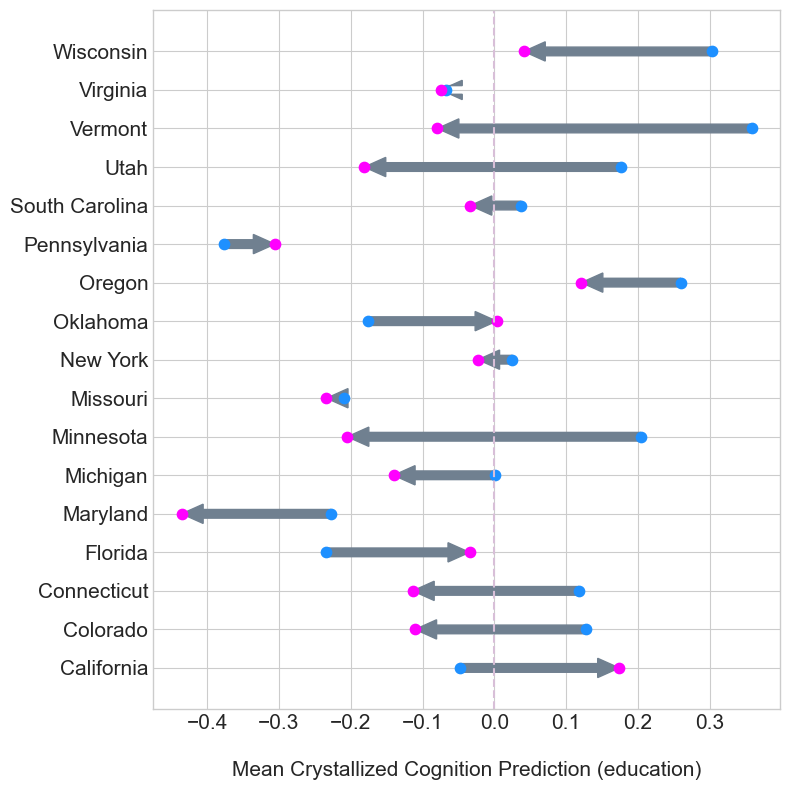

In [57]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (education)',size=15,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Education Attainment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_edu_crystallized_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [58]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.2655162646167988,
  -0.3435926198765731,
  -0.19715773987336851,
  -0.013202996432678343,
  0.15704459272780874],
 [0.11626643230805771,
  -0.3216459484328285,
  -0.11106281005471516,
  0.0416017678139045,
  0.03186146753497632])

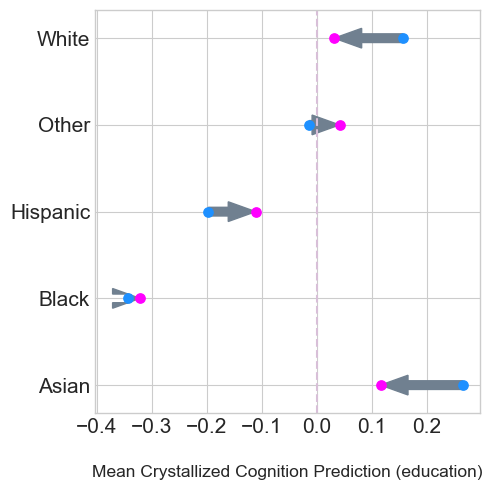

In [59]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Crystallized Cognition Prediction (education)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Education Attainment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_edu_crystallized_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_55959/467812702.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_55959/467812702.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


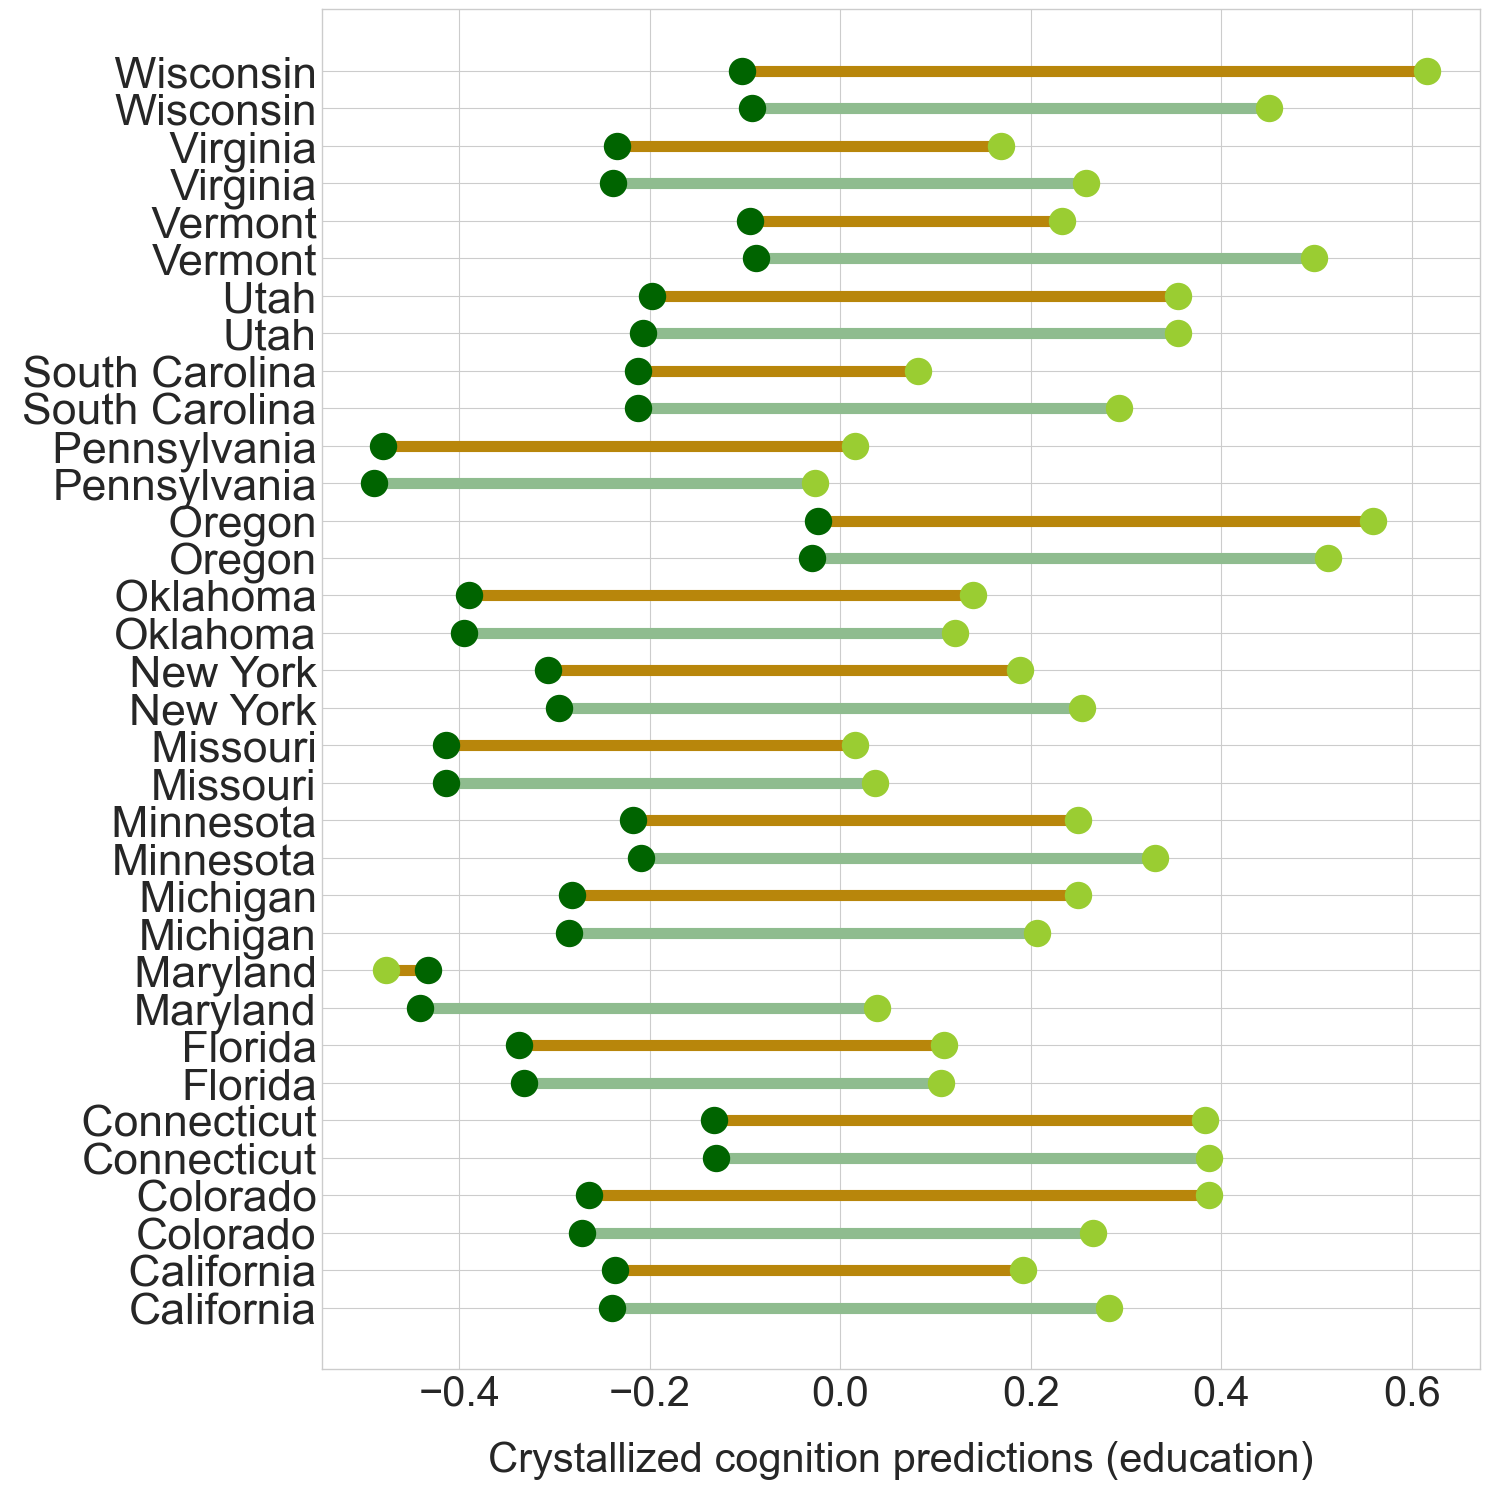

In [60]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkgreen', label='low edu', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='yellowgreen', label='high edu', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkgreen', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='yellowgreen', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (education)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low edu', 'high edu'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_edu_crystallized_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_55959/397364485.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_55959/397364485.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


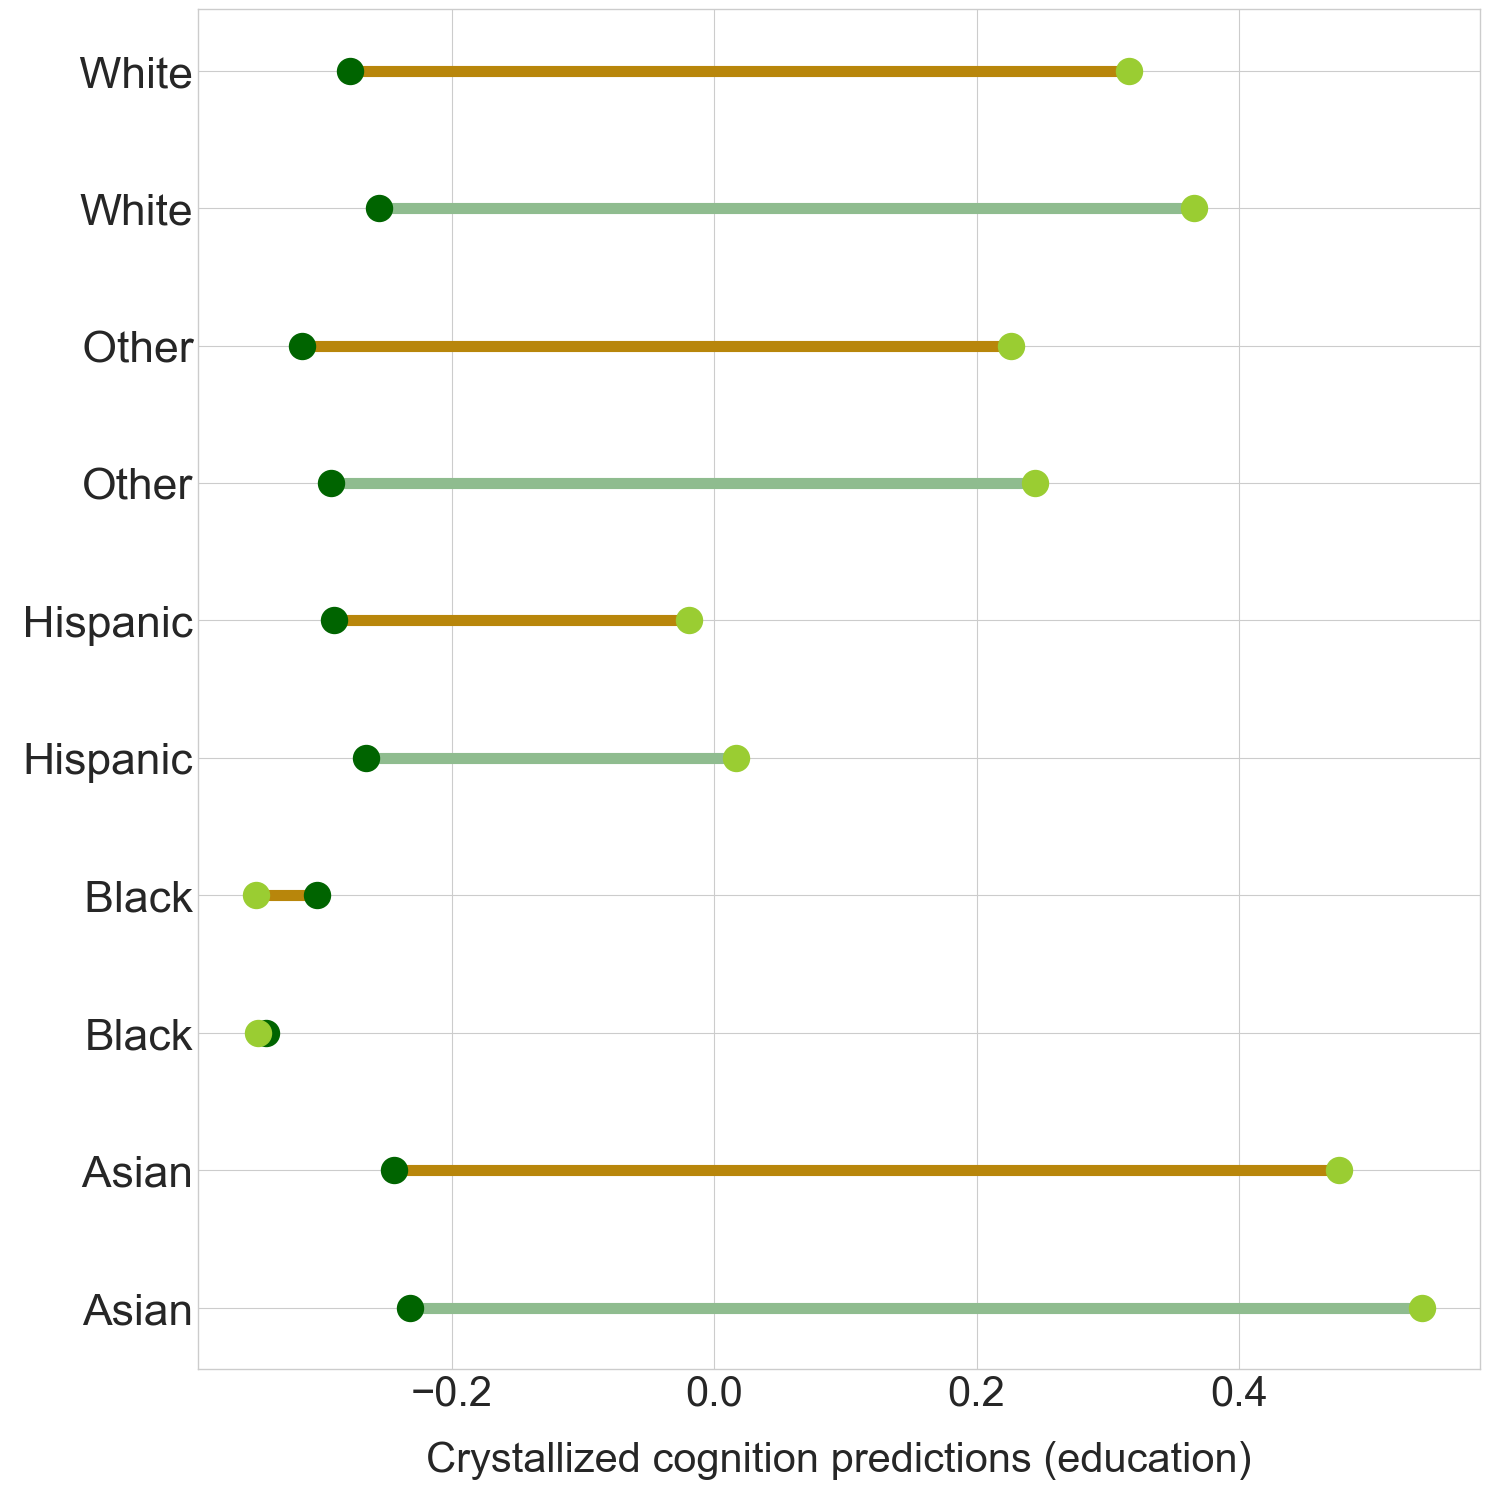

In [61]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='darkseagreen', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkgoldenrod', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkgreen', label='low edu', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='yellowgreen', label='high edu', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkgreen', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='yellowgreen', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Crystallized cognition predictions (education)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low edu', 'high edu'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_edu_crystallized_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()